# EML Decomposition plot for the FreeDOM paper

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

import math

import numpy as np
import matplotlib.pyplot as plt

from freedom.toy_model.toy_model import toy_experiment, lambda_d
from toy_NN_trafo import build_q_trafo, build_h_trafo

2022-01-24 12:10:23.832627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
np.random.seed(seed=12349)

In [3]:
# detector positions and time resolution
detector_xs = np.linspace(-5, 5, 5)
t_std = 1

c = 0.3 # m / ns

toy = toy_experiment(detector_xs)

In [4]:
import matplotlib.style as style
style.use('seaborn-colorblind')

In [5]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = 'dejavuserif'

In [6]:
example_x_src = 1.45
example_b_src = 1.1
example_N_src = 3.5

### Illustration of example experiment and expected pulse times and charges:

In [7]:
def plot_expectations(x_src, b_src, N_src, t_src=0, flat_axes=None):
    t_dists = [toy.get_p_d(x, t_src, x_src, b_src) for x in detector_xs]
    lambda_ds = lambda_d(detector_xs, x_src, b_src, N_src) 
    
    if flat_axes is None:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
        plt.subplots_adjust(hspace=0.4)

        flat_axes = axes.flat
        
    ax = next(flat_axes)
    for x_det, l_d in zip(detector_xs, lambda_ds):
        ax.bar([x_det], l_d)
        
    ax.set_yscale('log')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('$\Lambda_d$')
    ax.set_title('$\Lambda(x)$')
    
    ax.set_xlim(-6, 6)

    ax = next(flat_axes)
    for x_det, t_dist in zip(detector_xs, t_dists):
        mu = t_dist.mean()
        std = t_dist.std()
        times = np.linspace(mu - 3*std, mu + 3*std, 1000)
        ax.plot(times, t_dist.pdf(times), label=f'x={x_det:.0f}$\,$m')
    
    ax.set_title('$p_{d}(t)$')
    ax.set_xlabel('t (ns)')
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 2.33))
    
def plot_experiment(b, x, ax):
    
    # detector positions
    for i, det_x in enumerate(detector_xs):
        if i == 0:
            ax.plot([det_x], 0, 'o', markersize=5, label='sensor')
        else:
            ax.plot([det_x], 0, 'o', markersize=5)
    
    # light source
    ax.plot([x], [b], 'm*', markersize=15, label='light source')
    
    ax.plot([x, x], [0, b], 'k--')
    
    ax.text(x+0.15, b/2, '$b$', horizontalalignment='left', verticalalignment='center',
           fontdict={'size': 14})
    
    ax.plot([0, x], [0, b], 'k--')
    
    ax.text(x/2, b/2, '$r_0$', horizontalalignment='right', verticalalignment='bottom',
           fontdict={'size': 14})
    
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    
    ax.set_xlim(-6, 6)
    
    ax.legend(loc='upper left')
    
    ax.set_title('toy experiment setup')

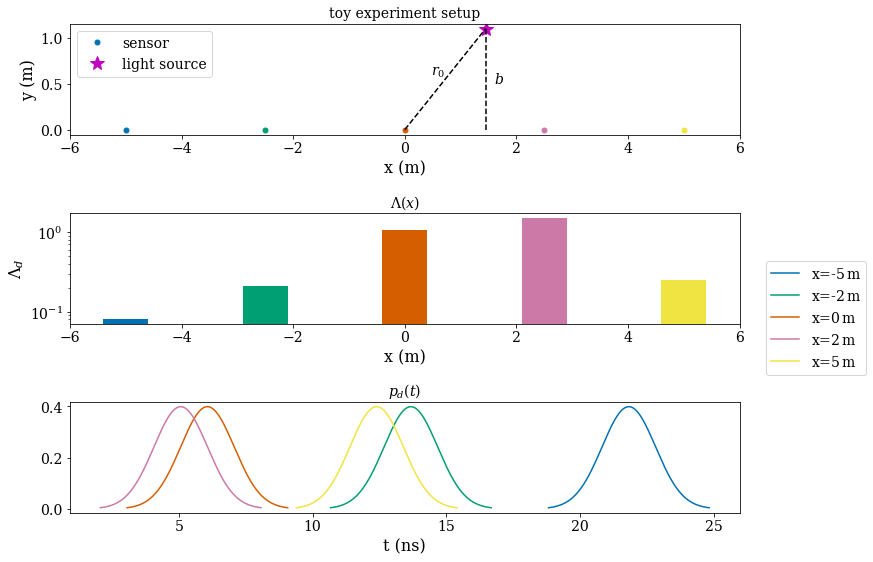

In [8]:
# plot_experiment(example_b_src, example_x_src)
# plt.show()
# plot_expectations(example_x_src, example_b_src, example_N_src)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
plt.subplots_adjust(hspace=0.7)
flat_axes = axes.flat
plot_experiment(example_b_src, example_x_src, next(flat_axes))
plot_expectations(example_x_src, example_b_src, example_N_src, flat_axes=flat_axes)

### Event generation code

In [9]:
# generate one event and plot it
event = toy.generate_event(x_src=example_x_src, b=example_b_src, N_src=example_N_src)

In [10]:
Ns = event[0][:, 0]
ts = event[1][:, 0]
ts_sensor_idx = event[1][:, -1]

In [11]:
def plot_event(Ns, ts, ts_sensor_idx, plot_expected=False,
               t_src=None, x_src=None, b_src=None, N_src=None):
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
    plt.subplots_adjust(hspace=0.5)
    
    flat_axes = axes.flat
    
    plot_experiment(example_b_src, example_x_src, next(flat_axes))
    
    Ns = event[0][:, 0]
    ax = next(flat_axes)
    for N, x_det in zip(Ns, detector_xs):
        ax.bar([x_det], [N], label=f'x={x_det:.0f} m')
            
    if plot_expected:
        lambda_ds = lambda_d(detector_xs, x_src, b_src, N_src)
        plt_xs = [detector_xs[0] - 1] + list(detector_xs) + [detector_xs[-1] + 1]
        plt_ys = [0] + list(lambda_ds) + [0]
        ax.step(plt_xs, plt_ys, 'k--', where='mid', label='$\Lambda_d$')
        
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.5))
    
    ax.set_xlim(-6, 6)
        
    ax.set_yscale('log')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('$Q_d$')
    ax.set_title('pulses per sensor')
    
    ax = next(flat_axes)
    ts = event[1][:, 0]
    ts_sensor_idx = event[1][:, -1]
    ts_sensor_idx = np.array(ts_sensor_idx)
    
    ax.set_title('hit times')
    ax.set_xlabel('t (ns)')
    
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i, x_det in enumerate(detector_xs):
        sensor_times = ts[ts_sensor_idx == i]
        if len(sensor_times) > 0:
            ax.bar(sensor_times, [0.25]*len(sensor_times), width=0.1, alpha=0.5,
                  color=color_cycle[i % len(color_cycle)])
    
        
        if plot_expected:
            t_dist = toy.get_p_d(x_det, t_src, x_src, b_src)
            mu = t_dist.mean()
            std = t_dist.std()
            times = np.linspace(mu - 3*std, mu + 3*std, 1000)
            ax.plot(times, t_dist.pdf(times))

    ax.set_yticklabels([])
    
    return fig

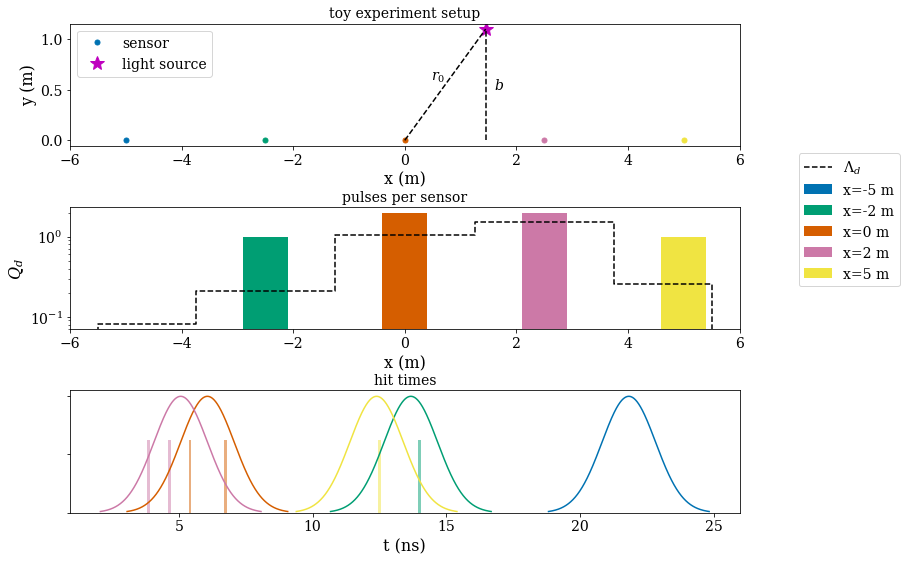

In [12]:
fig = plot_event(Ns, ts, ts_sensor_idx, 
                 plot_expected=True, x_src=example_x_src, b_src=example_b_src, N_src=example_N_src, t_src=0)
fig.savefig('toy_setup.pdf', bbox_inches='tight')

### Likelihood evaluation

In [13]:
def llh_scan(event, param_table):
    '''
    the columns of param_table shall be ordered as follows:
    hypo_xs, hypo_bs, hypo_ts, hypo_n_srcs
    
    Returns:
    
    dom_hit_terms: np.array
    
    dom_charge_terms: np.array
    
    total_charge_hit_terms: np.array
    
    total_charge_terms: np.array

    '''
    Ns, times = event
    
    n_params = len(param_table)
    
    dom_hit_terms = np.empty(n_params)
    dom_charge_terms = np.empty(n_params)
    total_charge_hit_terms = np.empty(n_params)
    total_charge_terms = np.empty(n_params)
    
    # store -llhs, multiply everything by -1
    for i in range(param_table.shape[0]):
        hypo_x, hypo_b, hypo_t, hypo_N_src = param_table[i, :]
    
        dom_hit_terms[i] = -toy.dom_hit_term(times, hypo_x, hypo_b, hypo_t)
    
        dom_charge_terms[i] = -toy.dom_charge_term(Ns, hypo_x, hypo_b, hypo_N_src)
    
        total_charge_hit_terms[i] = -toy.total_charge_hit_term(times,
                                                               hypo_x, hypo_b, hypo_t, hypo_N_src)
    
        total_charge_terms[i] = -toy.total_charge_term(Ns, hypo_x, hypo_b, hypo_N_src)
        
    return dom_hit_terms, dom_charge_terms, total_charge_hit_terms, total_charge_terms

In [14]:
grid_spacing = 400

In [15]:
def map_2d(event,
           inds, steps, 
           base_params=np.array([example_x_src, example_b_src, 0, example_N_src])):
           
    mg = np.meshgrid(*steps)
           
    n_hypotheses = mg[0].size
     
    param_table = np.repeat(base_params[np.newaxis, :], n_hypotheses, axis=0)

    for ind, coord in zip(inds, mg):
        param_table[:, ind] = coord.flat
           
    return llh_scan(event, param_table)

In [16]:
xs = np.linspace(-5.5, 5.5, grid_spacing)
bs = np.linspace(-2, 2, grid_spacing)

In [17]:
%%time
llh_pos_scan_res = map_2d(event, (0, 1), (xs, bs))

CPU times: user 23.5 s, sys: 400 ms, total: 23.9 s
Wall time: 23.5 s


### 2d plotting functions

In [18]:
cmap = 'viridis_r'

In [19]:
markersize = 5
marker = 'o'
markercolor='red'

def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar


def plot_scan(llh_scan_res, xs, ys, true_x, true_y, axis_labels, vmaxes):
    # copy to avoid modifying original scan results
    dom_hits, dom_charge, total_hits, total_charge = np.copy(llh_scan_res)
    
    dom_terms = dom_hits, dom_charge
    
    charge_terms = total_hits, total_charge
    
    gridsize = len(xs)
    
    xs = np.hstack([xs, [2*xs[-1] - xs[-2]]])
    ys = np.hstack([ys, [2*ys[-1] - ys[-2]]])
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 13.5),
                             gridspec_kw=dict(hspace=0.15, wspace=0.25))
    flat_axes = axes.flat
    for row, (terms, label) in enumerate(zip((dom_terms, charge_terms), ('per-sensor', 'total charge'))):
        ax = next(flat_axes)
        
        # subtract minimum value from each scan result
        for term in terms:
            term[:] -= term.min()
        
        m = ax.pcolormesh(xs, ys, terms[0].reshape(gridsize, gridsize), 
                          cmap=cmap, rasterized=True, linewidth=0, vmin=0, vmax=vmaxes[0])
        
        ax.plot([true_x], [true_y], marker=marker, markersize=markersize, color=markercolor)
        ax.set_xticks([])
        ax.set_ylabel(axis_labels[1])
        if label == 'per-sensor':
            ax.set_title(r'$-\sum_{i}~\ln~p_{s_i}(x_{i} | \theta)$')
        else:
            ax.set_title(r'$-\sum_{i}~\ln~p_{s_i}^{\mathrm{tot}}(x_{i} | \theta)$')
        colorbar(m)
        
        ax = next(flat_axes)
        m = ax.pcolormesh(xs, ys, terms[1].reshape(gridsize, gridsize), 
                          cmap=cmap, rasterized=True, linewidth=0, vmin=0, vmax=vmaxes[1])
        ax.plot([true_x], [true_y], marker=marker, markersize=markersize, color=markercolor)
        ax.set_xticks([])
        
        if row == 2:
            ax.set_xlabel(axis_labels[0])
        if label == 'per-sensor':
            ax.set_title(r'-$\sum_{s}~\left[N_s~\ln~\mathcal{N}_s(\theta) - \mathcal{N}_s(\theta)\right]$')
        else:
            ax.set_title(r'$-\left[N_{\mathrm{tot}}~\ln~\mathcal{N}_{\mathrm{tot}}(\theta) - \mathcal{N}_\mathrm{tot}(\theta)\right]$')
        
        colorbar(m)
        
        ax = next(flat_axes)
        sum_term = terms[0] + terms[1]
        sum_term = sum_term - sum_term.min()
        m = ax.pcolormesh(xs, ys, sum_term.reshape(gridsize, gridsize), 
                          cmap=cmap, rasterized=True, linewidth=0, vmin=0, vmax=vmaxes[2])
        ax.plot([true_x], [true_y], marker=marker, markersize=markersize, color=markercolor)
        ax.set_xticks([])
        
        if row == 2:
            ax.set_xlabel(axis_labels[0])
        ax.set_title('total')
        colorbar(m)
        
    # plot differences
    total_dom = sum(dom_terms)
    total_charge = sum(charge_terms)
    for dom, hit in zip(dom_terms + (total_dom,), charge_terms + (total_charge,)):
        ax = next(flat_axes)
        diff = (hit - hit.min()) - (dom - dom.min())
        
        vmin, vmax = None, None
        
        if np.abs(diff).max() < 1e-3:
            vmin, vmax = -0.05, 0.05
        m = ax.pcolormesh(xs, ys, diff.reshape(gridsize, gridsize), 
                          cmap=cmap, rasterized=True, linewidth=0, vmin=vmin, vmax=vmax)
        colorbar(m)
        ax.set_title('difference')
        
    axes[2][0].set_ylabel(axis_labels[1])

    for i in range(3):
        axes[2][i].set_xlabel(axis_labels[0])
        for col in range(1, 3):
            axes[i][col].set_yticks([])
            
        
    return fig

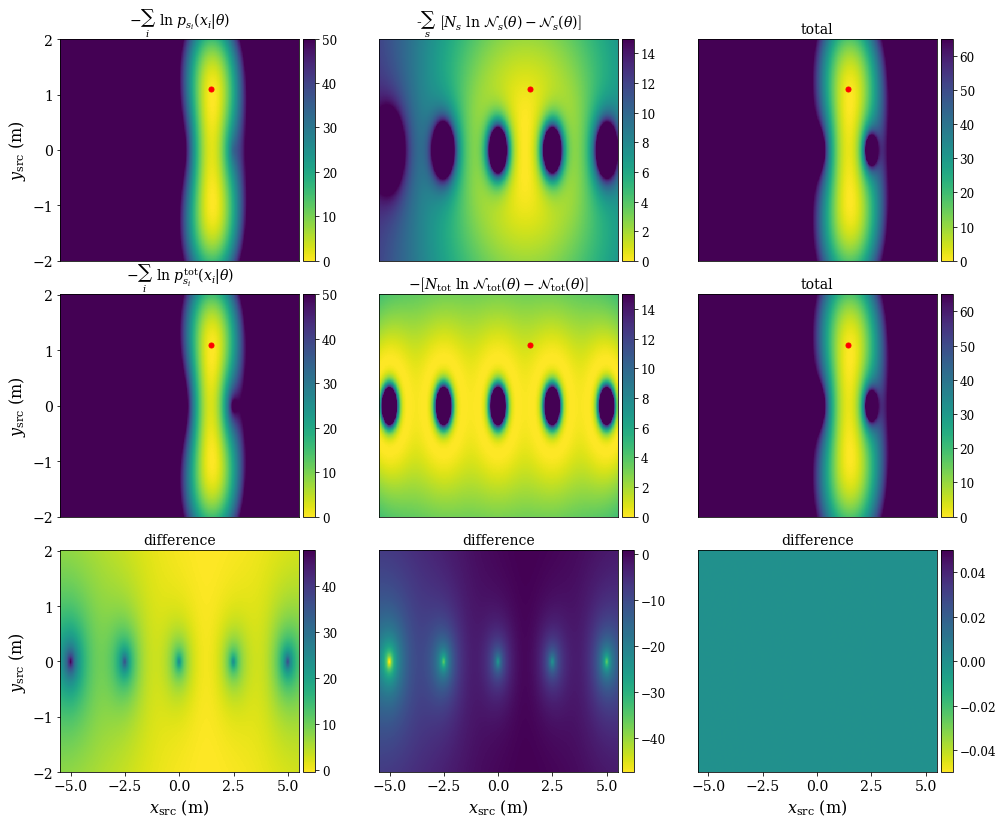

In [20]:
fig = plot_scan(llh_pos_scan_res, xs, bs, example_x_src, example_b_src,
                axis_labels=['$x_{\mathrm{src}}$ (m)', '$y_{\mathrm{src}}$ (m)'], vmaxes=[50, 15, 65])
plt.savefig('eml_decomp.pdf', bbox_inches='tight')

### Plot with approximate NN likelihoods

In [21]:
import tensorflow as tf

In [22]:
chargenet = tf.keras.models.load_model('paper_toy_chargenet.h5', custom_objects=dict(q_trafo=build_q_trafo(toy.detector_xs)))
hitnet = tf.keras.models.load_model('paper_toy_hitnet.h5', custom_objects=dict(h_trafo=build_h_trafo(toy.detector_xs)))

for m in hitnet, chargenet:
    m.layers[-1].activation = tf.keras.activations.linear

2022-01-24 12:10:59.195232: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-24 12:10:59.197419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-24 12:10:59.213193: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-24 12:10:59.213278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: schwyz
2022-01-24 12:10:59.213296: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: schwyz
2022-01-24 12:10:59.213509: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 418.56.0
2022-01-24 12:10:59.213582: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 418.56.0
2022-01-24 12:10:59.213598: I tensorflow/stream_executor/cuda/cud

In [23]:
n_hits = len(ts)
grid_x, grid_b = np.meshgrid(xs, bs)

t = np.vstack([grid_x.flat, grid_b.flat, np.full(len(xs)*len(bs), example_N_src)]).T
chgnet_x = np.full(len(xs)*len(bs), n_hits)[:, np.newaxis]
chgnet_map = -chargenet.predict([chgnet_x, t])[:, -1]

hitnet_xs = event[1]
hitnet_ts = np.repeat(t, n_hits, axis=0)
hitnet_map = -hitnet.predict([np.tile(hitnet_xs, (len(xs)*len(bs), 1)), hitnet_ts]).reshape((-1, n_hits)).sum(axis=1)

2022-01-24 12:10:59.583286: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-24 12:10:59.583843: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2394785000 Hz


In [24]:
total_map = hitnet_map + chgnet_map

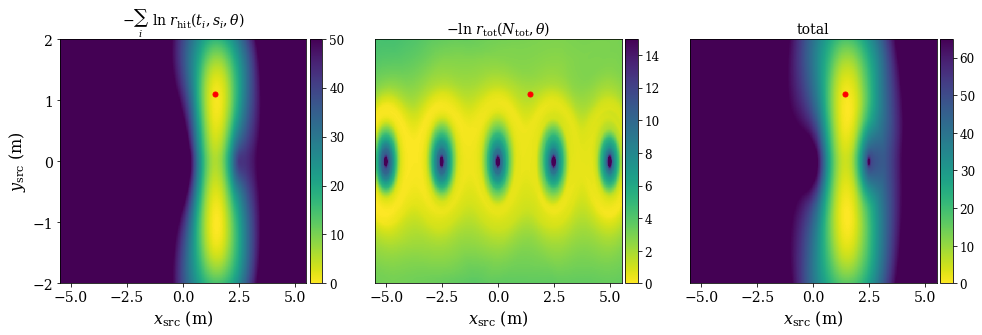

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4.5), gridspec_kw=dict(hspace=0.15))

grid_xs = np.hstack([xs, [2*xs[-1] - xs[-2]]])
grid_ys = np.hstack([bs, [2*bs[-1] - bs[-2]]])

for ax, llh_map, vmax in zip(axes.flat, [hitnet_map, chgnet_map, total_map], [50, 15, 65]):
    shifted_map = llh_map - llh_map.min()
    m = ax.pcolormesh(grid_xs, grid_ys, shifted_map.reshape((len(bs), len(xs))), 
                   cmap=cmap, rasterized=True, linewidth=0, vmin=0, vmax=vmax)
    colorbar(m)
    ax.plot([example_x_src], [example_b_src], marker=marker, markersize=markersize, color=markercolor)
    
axes[0].set_ylabel('$y_{\mathrm{src}}$ (m)')
for i in range(3):
    axes[i].set_xlabel('$x_{\mathrm{src}}$ (m)')
    if i != 0:
        axes[i].set_yticks([])
    
axes[0].set_title(r'$-\sum_{i}~\ln~r_\mathrm{hit}(t_i, s_i, \theta)$')
axes[1].set_title(r'$-\ln~r_{\mathrm{tot}}(N_{\mathrm{tot}}, \theta)$')
axes[2].set_title('total')

fig.savefig('toy_example_nns.pdf', bbox_inches='tight')